In [2]:
import yfinance as yf

import pandas as pd
import matplotlib.pyplot as plt

[*********************100%***********************]  3 of 3 completed


<Axes: xlabel='Date'>

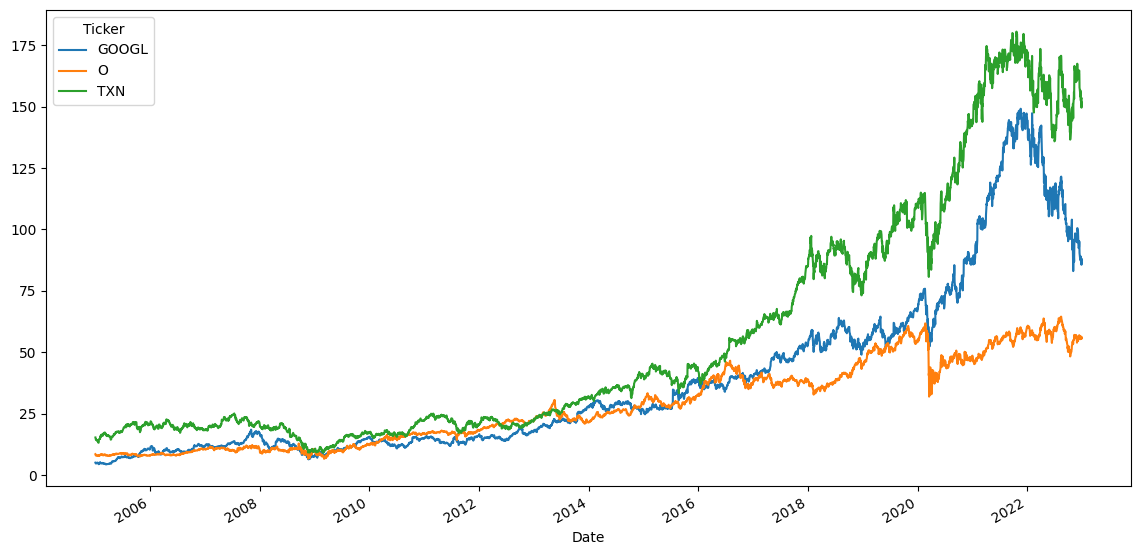

In [137]:
tickers = ['O', 'TXN', 'GOOGL']

data = yf.download(tickers, start="2005-01-01", end="2023-01-01")

if data is not None and 'Close' in data:
    df = data['Close']
else:
    raise ValueError("Data download failed or 'Close' prices not found in the data.")

df.plot(figsize=(14, 7))


In [138]:
na_rows = df.isna().sum()
print("Number of NaN rows for each ticker:")
print(na_rows)

Number of NaN rows for each ticker:
Ticker
GOOGL    0
O        0
TXN      0
dtype: int64


In [139]:
df.dropna()

Ticker,GOOGL,O,TXN
Date,,,
2005-01-03,5.048685,8.512182,15.295337
2005-01-04,4.844206,8.433931,14.928454
2005-01-05,4.819551,8.005255,14.479335
2005-01-06,4.696017,8.012064,14.422403
2005-01-07,4.828019,7.961027,14.498312
...,...,...,...
2022-12-23,88.805428,56.451736,152.524902
2022-12-27,86.974174,56.188797,151.968155
2022-12-28,85.610695,55.417515,149.564987


In [140]:
daily_returns_df = df.pct_change().dropna()

In [141]:
def calculate_portfolio_return(daily_returns: pd.DataFrame, weights: list) -> pd.Series:
    if len(weights) != len(daily_returns.columns):
        raise ValueError("Weights must match the number of tickers.")
    return (daily_returns * weights).sum(axis=1)

def calculate_portfolio_volatility(daily_returns: pd.DataFrame, weights: list) -> float:
    if len(weights) != len(daily_returns.columns):
        raise ValueError("Weights must match the number of tickers.")
    weighted_returns = daily_returns.dot(weights)
    return weighted_returns.std() * (252 ** 0.5)  # Annualized volatility

In [142]:
# now do the calculations for the three stocks - stepping by 1 % for the weights
all_weights_combinations = []
for w1 in range(0, 101, 1):
    for w2 in range(0, 101 - w1, 1):
        w3 = 100 - w1 - w2
        if w3 < 0:
            continue
        weights = [w1 / 100, w2 / 100, w3 / 100]
        all_weights_combinations.append(weights)

print(f"Total combinations of weights: {len(all_weights_combinations)}")



Total combinations of weights: 5151


In [143]:
portfolios = pd.DataFrame()

results = []
for weights in all_weights_combinations:
    port_return = calculate_portfolio_return(daily_returns_df, weights).mean() * 252  # annualized return
    port_volatility = calculate_portfolio_volatility(daily_returns_df, weights)
    results.append({
        'w1': weights[0],
        'w2': weights[1],
        'w3': weights[2],
        'annual_return': port_return,
        'annual_volatility': port_volatility,
    })

portfolios = pd.DataFrame(results)

In [144]:
print(portfolios)

        w1    w2    w3  annual_return  annual_volatility
0     0.00  0.00  1.00       0.170934           0.291979
1     0.00  0.01  0.99       0.170802           0.290393
2     0.00  0.02  0.98       0.170669           0.288838
3     0.00  0.03  0.97       0.170537           0.287314
4     0.00  0.04  0.96       0.170405           0.285823
...    ...   ...   ...            ...                ...
5146  0.98  0.01  0.01       0.203125           0.297554
5147  0.98  0.02  0.00       0.202992           0.297357
5148  0.99  0.00  0.01       0.203587           0.299345
5149  0.99  0.01  0.00       0.203454           0.299125
5150  1.00  0.00  0.00       0.203916           0.300924

[5151 rows x 5 columns]


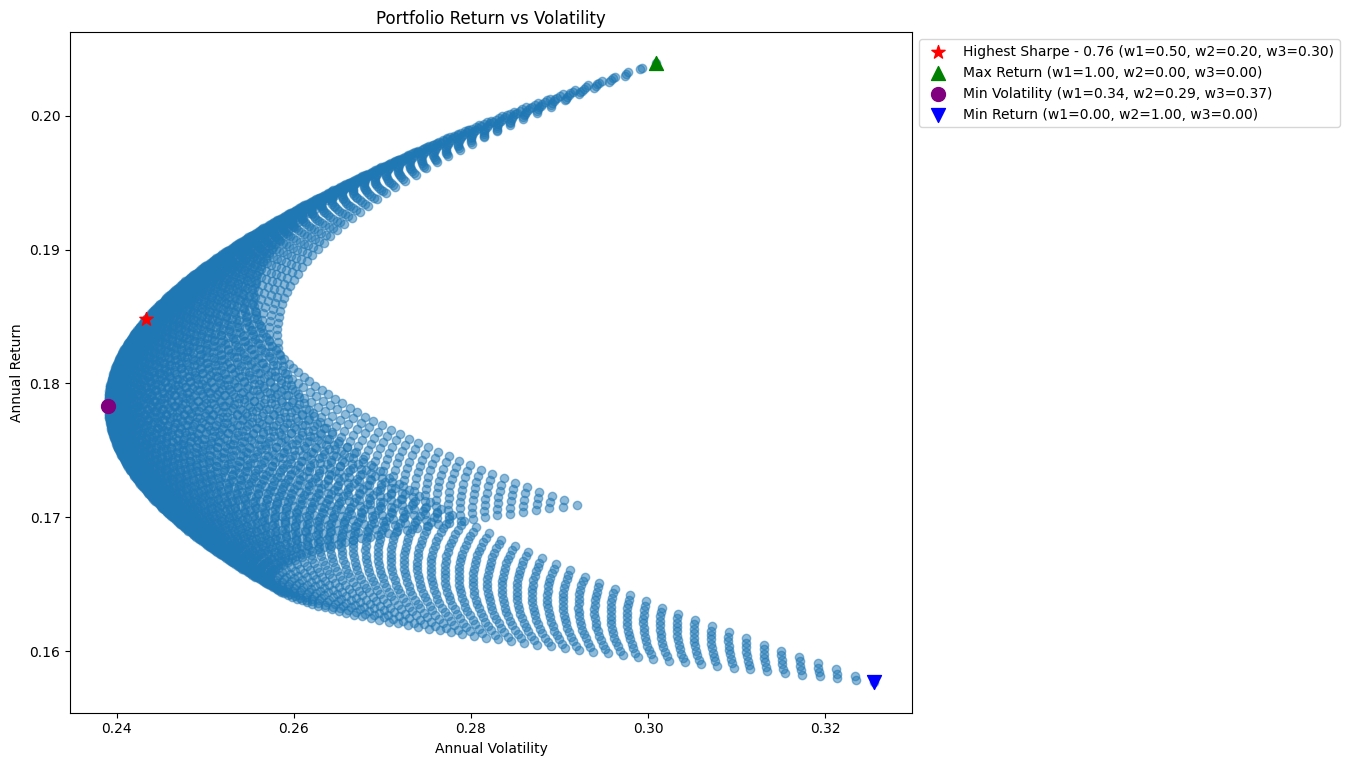

In [145]:
plt.scatter(
    portfolios['annual_volatility'],
    portfolios['annual_return'],
    alpha=0.5,
)
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.title('Portfolio Return vs Volatility')

# Find portfolio with highest Sharpe ratio (best risk-return trade-off)
portfolios['sharpe_ratio'] = portfolios['annual_return'] / portfolios['annual_volatility']
max_sharpe_idx = portfolios['sharpe_ratio'].idxmax()
max_sharpe_ratio = portfolios['sharpe_ratio'].max()
max_sharpe_portfolio = portfolios.loc[max_sharpe_idx]

# Find portfolio with highest return (and highest volatility)
max_return_idx = portfolios['annual_return'].idxmax()
max_return_portfolio = portfolios.loc[max_return_idx]

# Find portfolio with lowest return
min_return_idx = portfolios['annual_return'].idxmin()
min_return_portfolio = portfolios.loc[min_return_idx]

# Add these points to the plot
plt.scatter(max_sharpe_portfolio['annual_volatility'], max_sharpe_portfolio['annual_return'], 
            color='red', s=100, marker='*', label=f'Highest Sharpe - {max_sharpe_ratio:.2f} (w1={max_sharpe_portfolio["w1"]:.2f}, w2={max_sharpe_portfolio["w2"]:.2f}, w3={max_sharpe_portfolio["w3"]:.2f})')

plt.scatter(max_return_portfolio['annual_volatility'], max_return_portfolio['annual_return'], 
            color='green', s=100, marker='^', label=f'Max Return (w1={max_return_portfolio["w1"]:.2f}, w2={max_return_portfolio["w2"]:.2f}, w3={max_return_portfolio["w3"]:.2f})')
            # Find portfolio with lowest volatility
min_volatility_idx = portfolios['annual_volatility'].idxmin()
min_volatility_portfolio = portfolios.loc[min_volatility_idx]

# Add lowest volatility portfolio to the plot
plt.scatter(min_volatility_portfolio['annual_volatility'], min_volatility_portfolio['annual_return'], 
            color='purple', s=100, marker='o', label=f'Min Volatility (w1={min_volatility_portfolio["w1"]:.2f}, w2={min_volatility_portfolio["w2"]:.2f}, w3={min_volatility_portfolio["w3"]:.2f})')

plt.scatter(min_return_portfolio['annual_volatility'], min_return_portfolio['annual_return'], 
            color='blue', s=100, marker='v', label=f'Min Return (w1={min_return_portfolio["w1"]:.2f}, w2={min_return_portfolio["w2"]:.2f}, w3={min_return_portfolio["w3"]:.2f})')

# Adjust the figure size to make it wider
plt.gcf().set_size_inches(16, 8)

# Add legend with better positioning
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.03, 0.85, 1])